**Introduction**

In this Lab, we explore frequency domain filtering, including filter design and applications to image restoration. We explore the characteristics of images and image transformations in the frequency domain, as well as spatial reconstruction from Fourier components. Noise reduction utilizing ideal and Gaussian low-pass filters is compared in terms of visual quality and PSNR. A Frequency domain filter is designed based on the spatial and frequency domain characteristics of a noisy image.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from skimage.io import imread
from skimage.transform import rotate
from skimage.color import rgb2gray
from skimage.morphology import disk
from skimage.metrics import peak_signal_noise_ratio as PSNR
from scipy import signal


def gaussian_filter(n_rows, n_cols, stdv):
    """
    Returns a 2d Gaussian image filter.
    """
    g_r = signal.windows.gaussian(n_rows, stdv)
    g_c = signal.windows.gaussian(n_cols, stdv)

    G = np.outer(g_r, g_c)

    return G/np.max(G)

plt.gray()

lena= rgb2gray(imread('lena2.tiff'))
frequnoisy = imread('frequnoisy.tif').astype(np.float64)/255

<Figure size 640x480 with 0 Axes>

**Part 2 - Fourier Analysis**

Text(0.5, 1.0, 'Test Image')

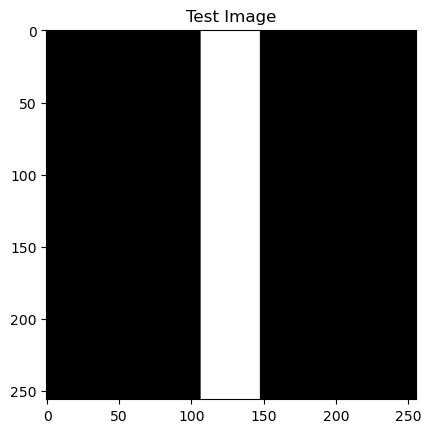

In [ ]:
# original test image (vertical white bar on black background)
f = np.zeros((256,256))
f[:,107:148] = 1

plt.figure()
plt.imshow(f)
plt.title('Test Image')


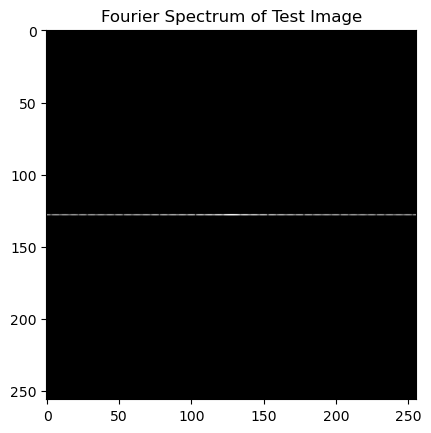

In [ ]:
# fourier spectrum of the test image
F = np.fft.fftshift(np.fft.fft2(f))
plt.figure()
plt.imshow(np.log(1+np.abs(F)), cmap='gray')
plt.title('Fourier Spectrum of Test Image')
plt.show()

**1. What can you say about the general distribution of energy in the Fourier spectra? Why?**

It seems that most of the energy is concentrated at the center of the Fourier spectrum. This is because the pixel intensities are mostly constant, with a couple sharp transitions at the edges of the white rectangle. This image contains mostly low frequency components which is represents in the frequency domain with slow and smooth variations.

**2. What characteristics about the test image can you infer from the Fourier spectra?**

The orientation of the rectangle can be predicted since the spectrum is showing horizontal bands, indicating that there are strong horizontal frequency components, as would be seen in a vertical rectangle. The sharpness of the rectangle edges can also be interpreted from the brightness fading away from the center in the Fourier spectrum.

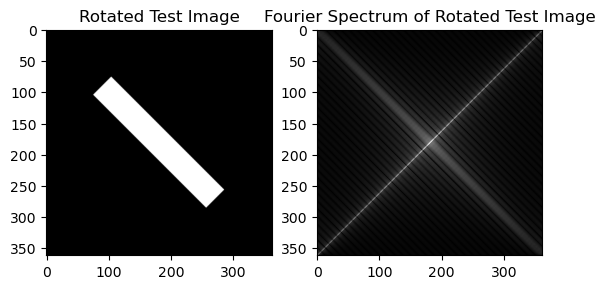

In [ ]:
# rotated image fourier spectrum
f_rotated = rotate(f, 45, resize=True)
F_rotated = np.fft.fftshift(np.fft.fft2(f_rotated))

plt.figure()
plt.subplot(1,2,1)
plt.imshow(f_rotated)
plt.title('Rotated Test Image')

plt.subplot(1,2,2)
plt.imshow(np.log(1+np.abs(F_rotated)), cmap='gray')
plt.title('Fourier Spectrum of Rotated Test Image')
plt.show()

**3. How did the Fourier spectra change from the original image (before rotation)?**

When you rotate the test image by 45°, the Fourier spectrum also rotates by the same angle. The energy spectrum is still concentrated at the spectrum, and less concentrated the further you go out.

**4. What conclusions and observations can be made about image characteristics based on the Fourier spectra of both original image and the rotated image?**

The orientation of structures in the image directly corresponds to the orientation of patterns in the Fourier spectrum, as they are rotated by the same angle. In terms of spectra energy location, the spread stays the same, clarifying that frequency content is not varied, only it's rotation.


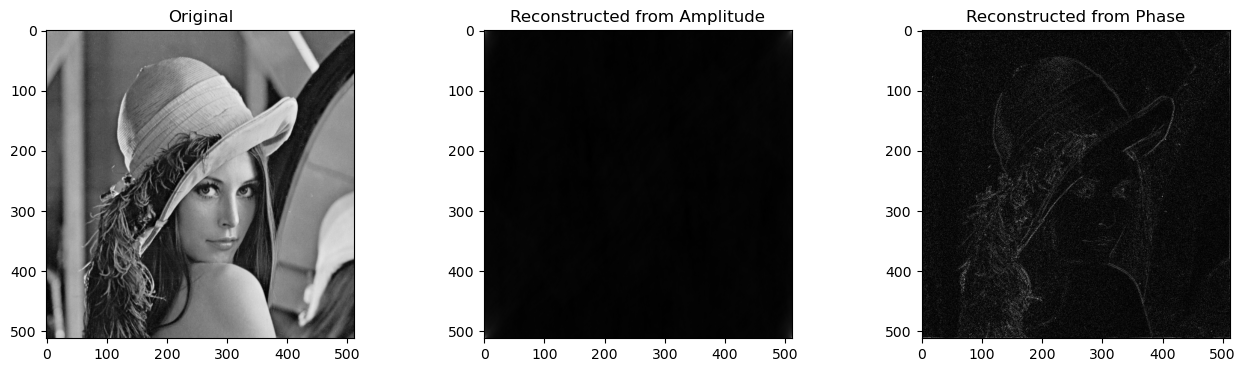

<Figure size 640x480 with 0 Axes>

In [ ]:
L = np.fft.fftshift(np.fft.fft2(lena))
A = np.abs(L)
theta = L / A

reconstructed_amp = np.fft.ifft2(np.fft.ifftshift(A)).real
reconstructed_theta = np.fft.ifft2(np.fft.ifftshift(theta)).real

plt.figure(figsize=(16,4))
plt.subplot(1,3,1)
plt.imshow(lena)
plt.title('Original')
plt.subplot(1,3,2)
plt.imshow(reconstructed_amp)
plt.title('Reconstructed from Amplitude')
plt.subplot(1,3,3)
plt.imshow(np.abs(reconstructed_theta))
plt.title('Reconstructed from Phase')
plt.show()
plt.tight_layout()

**5. Describe how the reconstructed image from the amplitude component look like?**
**What image characteristics does the amplitude component capture?**

The amplitude component is not good at capturing any image components. This makes sense as the spatial information is all gone in the reconstructed amplitude image.

**6. Describe how the reconstructed image from the phase component look like? What image characteristics does the phase component capture?**
The phase spectrum gives information on the edges in the lena image. The phase component captures the shapes, edges and contours in the image.

**3 Noise Reduction in the Frequency Domain**

Let us now study noise reduction techniques based on frequency domain filtering as well as the effect of filter
parameters on image quality. Load the Lena image (adjust intensities to range of 0 to 1) and apply additive
Gaussian noise with variance of 0.005 to the image. The function skimage.util.random noise will be useful.
Plot the Log Fourier spectra of the original image and the noisy image by using the np.log function on the
Fourier spectra.

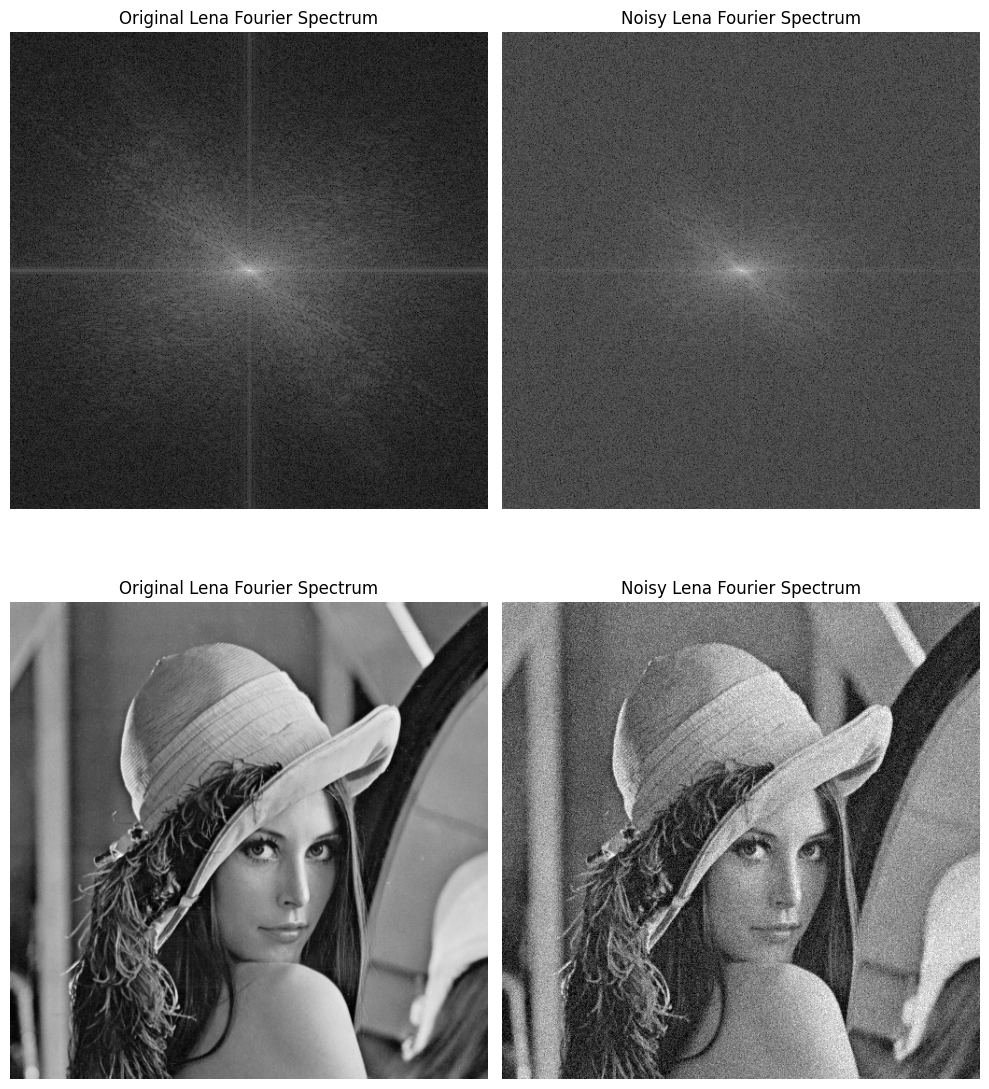

In [4]:
import skimage.util

from scipy.fft import fft2, fftshift

lena = imread('lena2.tiff').astype(np.float64)/255
lena = rgb2gray(lena)
lena_gaussian = skimage.util.random_noise(lena, mode='gaussian', mean=0, var=0.005)

# transform of original image
lena_spec = np.fft.fftshift(np.fft.fft2(lena))

# gaussian blurred image
lena_spec_g = np.fft.fftshift(np.fft.fft2(lena_gaussian))

fig, axes = plt.subplots(2, 2, figsize=(10,12))

axes[0,0].imshow(np.log(1+np.abs(lena_spec)), cmap='gray')
axes[0,0].set_title('Original Lena Fourier Spectrum')
axes[0,0].axis('off')

axes[0,1].imshow(np.log(1+np.abs(lena_spec_g)), cmap='gray')
axes[0,1].set_title('Noisy Lena Fourier Spectrum')
axes[0,1].axis('off')

axes[1,0].imshow(lena, cmap='gray')
axes[1,0].set_title('Original Lena Fourier Spectrum')
axes[1,0].axis('off')

axes[1,1].imshow(lena_gaussian, cmap='gray')
axes[1,1].set_title('Noisy Lena Fourier Spectrum')
axes[1,1].axis('off')

plt.tight_layout()
plt.show()



**7. Compare the two Fourier spectra. What are the differences? Where are these differences most visually
prominent? Why?**

The original image Fourier spectrum has most of its energy towards the central low frequencies, and has a dark peripheral area, suggesting that the original image has many smooth regions and fewer sharp transitions. The horizontal/vertical lines present in the original spectrum are less obvious in the noisy spectrum. This is because gaussian noise introduces high frequency content to the image, which adds energy across the peripheral high frequency regions of the spectrum, making these features less obvious.

Now let us study the ideal low-pass filter. To create an ideal low-pass filter with a cut-off radius r, first you
need to create an image of a white circle with radius r. One approach to do use the skimage.morphology.disk
function in the following way:
from skimage.morphology import disk
h = disk(r)
Now create a black image (representing an energy-less Fourier spectra) and center the circle onto the black
image:
h freq = np.zeros(image size)
h freq[height of image//2-r: height of image//2+r+1, width of image//2-r: width of image//2+r+1] = h
Create and plot the Fourier spectra of the resulting low-pass filter h f req with a radius of 60. Now, apply
the filter on the noisy image in the frequency domain and then perform an inverse Fourier transform. Plot
the resulting denoised image and the corresponding PSNR.

PSNR: 27.45877419210242


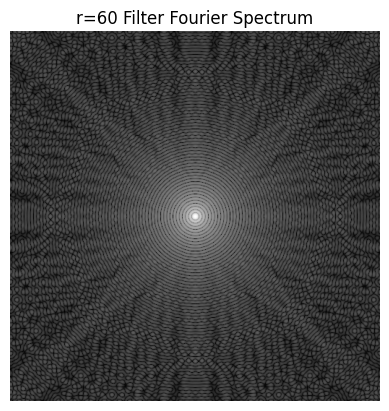

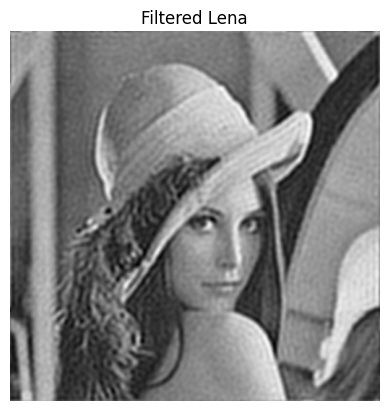

In [5]:
from skimage.morphology import disk
r = 60
h = disk(r)
filter_size = 512
h_freq = np.zeros((filter_size, filter_size), dtype=np.uint8)
h_freq[filter_size//2-r: filter_size//2+r+1, filter_size//2-r: filter_size//2+r+1] = h

h_freq_spec = np.fft.fftshift(np.fft.fft2(h_freq))

# plt.figure()
# plt.imshow(h_freq, cmap='gray')
# plt.title('Filter Fourier Spectrum')
# plt.axis('off')

plt.figure()
plt.imshow(np.log(1+np.abs(h_freq_spec)), cmap='gray')
plt.title('r=60 Filter Fourier Spectrum')
plt.axis('off')

# apply filter in freq domain
filtered_lena_f = h_freq * lena_spec_g
filtered_lena = np.fft.ifft2(np.fft.ifftshift(filtered_lena_f)).real

plt.figure()
plt.imshow(filtered_lena, cmap='gray')
plt.title('Filtered Lena')
plt.axis('off')

psnr = PSNR(lena, filtered_lena)
print("PSNR:", psnr)

**8. Describe the appearance of the denoised image compared to the original and the noisy images. Why
does it look this way? What does the ideal low-pass filter do?**

The denoised image appears blurred compared to the original and noisy images, and has ringing artifacts present. As this is a low-pass filter, the blurring/removal of high-frequency content is to be expected.

**9. There is a particular artifact present in the restored image. What is it and why does it happen?**

Aside from being blurred, the restored image also displays subtle/narrow ringing artifacts. The inverse fourier transform of the ideal LPF is a sinc function, which has side lobes that are proportional to the filter radius. When this filter is convolved with the noisy image, the edges of the filtered image (effectively a step function) display ringing on both sides, as seen in the result image.


Now create a low-pass filter with a cut-off radius of 20 and apply it to the noisy image in the frequency
domain and then perform an inverse Fourier transform. Plot the resulting denoised image and the corresponding PSNR.

PSNR: 22.509158687186755


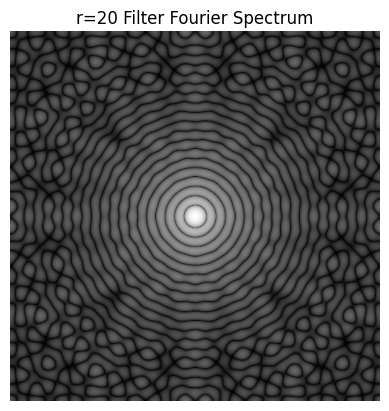

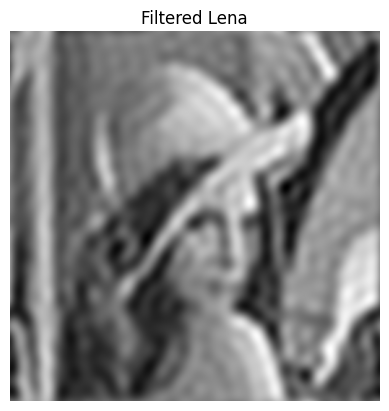

In [6]:
r = 20
h = disk(r)
filter_size = 512
h_freq = np.zeros((filter_size, filter_size), dtype=np.uint8)
h_freq[filter_size//2-r: filter_size//2+r+1, filter_size//2-r: filter_size//2+r+1] = h

h_freq_spec = np.fft.fftshift(np.fft.fft2(h_freq))

# plt.figure()
# plt.imshow(h_freq, cmap='gray')
# plt.title('Filter Fourier Spectrum')
# plt.axis('off')

plt.figure()
plt.imshow(np.log(1+np.abs(h_freq_spec)), cmap='gray')
plt.title('r=20 Filter Fourier Spectrum')
plt.axis('off')

# apply filter in freq domain
filtered_lena_f = h_freq * lena_spec_g
filtered_lena = np.fft.ifft2(np.fft.ifftshift(filtered_lena_f)).real

plt.figure()
plt.imshow(filtered_lena, cmap='gray')
plt.title('Filtered Lena')
plt.axis('off')

psnr = PSNR(lena, filtered_lena)
print("PSNR:", psnr)

**10. Compare the denoised image with the denoised image using a cut-off radius of 60. How does the
image and the PSNR differ? Why?**

This image experinces much more obvious, wide ringing artifacts than the image with the high cut-off radius, and is significantly more blurred. This is because a narrower cut-off radius in the ILPF results in wider lobes in the corresponding sinc function, which then produces a stronger ringing effect in the final image. The PSNR is lower than the filtered image obtained with a 60px cut-off radius, which is to be expected, as this image has much stronger blurring, reducing its similarity compared to the original image.

**11. What conclusions can you draw about the relationship between cut-off radius and resulting image after filtering? What is the trade-off in terms of noise reduction?**

A smaller cutoff radius will produce a more blurred result image, with stronger/larger ringing artifacts, whereas a filter with a larger cutoff radius will produce a less blurred result image, with weaker/smaller ringing artifacts. It seems that in order to achieve greater noise reduction (in terms of blurring), it must be accepted that the result will also experience more ringing artifacts.

Now let’s do the same thing with a Gaussian low-pass filter. Create a Gaussian low-pass filter kernel with a
standard deviation of 60 and normalize it based on the highest value in the kernel. The Gaussian low-pass
filter can be created using the provided gaussian filter function.
Apply the Gaussian low-pass filter to the noisy image in the frequency domain and then perform an inverse
Fourier transform. Plot the resulting denoised image and the corresponding PSNR.

PSNR: 29.24522522441576


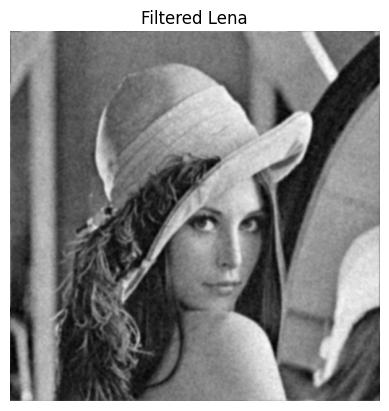

In [ ]:
# gaussian low pass filter
n_rows, n_cols = lena.shape
gauss_LP = gaussian_filter(n_rows, n_cols, stdv=60)
gauss_LP = gauss_LP/(np.max(gauss_LP)) # normalize

# apply filter in freq domain
filtered_lena_f = gauss_LP * lena_spec_g
filtered_lena = np.fft.ifft2(np.fft.ifftshift(filtered_lena_f)).real

plt.figure()
plt.imshow(filtered_lena, cmap='gray')
plt.title('Filtered Lena')
plt.axis('off')

psnr = PSNR(lena, filtered_lena)
print("PSNR:", psnr)


**12. Compare the denoised image with the denoised images produced using the ideal low-pass filters. How
does the image and the PSNR differ? Is it better or worse? Why? Does it have the same type of image
artifacts?**

The image is gently blurred, lacking the artifacts present in the images produced with the ideal low-pass filters, though some of the noise still remains. The gaussian denoised image has the highest PSNR compared to the ideal low-pass filter results. The visual quality of the image is also superior, as it doesn't significantly blur the image, and does not have the ringing artifacts. This is because the inverse fourier transform of the gaussian LPF is still a gaussian, which has no side lobes present, resulting in a filtered image without any ringing.

**Part 4 - Filter Design**

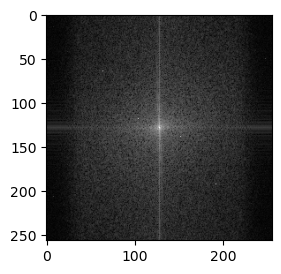

In [ ]:
# fft of noisy frequency image
F_noisy = np.fft.fftshift(np.fft.fft2(frequnoisy))
mag_F_noisy = np.log1p(np.abs(F_noisy))
plt.figure()
plt.subplot(1,2,1)
plt.imshow(mag_F_noisy, cmap='gray')

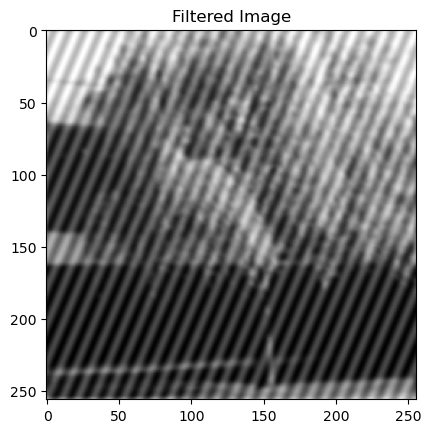

In [ ]:
# the spectrum above shows one high energy peak at the center, that spans both horizontal and vertical directions.
# a filter that blocks these frequencies would be ideal to remove the noise.

# step 1: design a low-pass Gaussian filter
n_rows, n_cols = frequnoisy.shape
G_LP = gaussian_filter(n_rows, n_cols, stdv=30) # larger stdv for smoother image

F_filtered = F_noisy * G_LP
f_filtered = np.fft.ifft2(np.fft.ifftshift(F_filtered)).real

plt.imshow(f_filtered, cmap='gray')
plt.title('Filtered Image')
plt.show()

This image removes som of the noise, but clearly blurs the image too much, hence maybe a Gaussian filter is not adequete. Next we will try a notch reject filter, to only supress the noise around the mean and variance

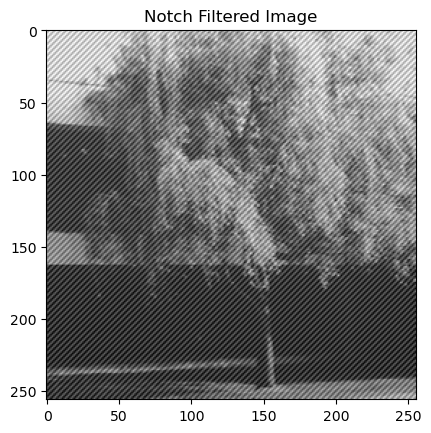

In [ ]:
# step 2: design a notch reject filter to remove the noise frequency only
def notch_reject_filter(shape, u0, v0, D0=10):
    M, N = shape
    U, V = np.meshgrid(np.arange(-N//2, N//2), np.arange(-M//2, M//2))
    D1 = np.sqrt((U - u0)**2 + (V - v0)**2)
    D2 = np.sqrt((U + u0)**2 + (V + v0)**2)
    H = 1 / (1 + (D0**2 / (D1 * D2 + 1e-5)))
    return H


center = np.array(mag_F_noisy.shape) // 2
magnitude_centered = mag_F_noisy.copy()
magnitude_centered[center[0]-10:center[0]+10, center[1]-10:center[1]+10] = 0  # ignore center peak

# find noise frequency peak
v0, u0 = np.unravel_index(np.argmax(magnitude_centered), magnitude_centered.shape)
u0_offset = u0 - center[1]
v0_offset = v0 - center[0]

H = notch_reject_filter(frequnoisy.shape, u0_offset, v0_offset, D0=1)

F_filtered = F_noisy * H
f_filtered = np.fft.ifft2(np.fft.ifftshift(F_filtered)).real
plt.imshow(f_filtered, cmap='gray')
plt.title('Notch Filtered Image')
plt.show()



The above image does a good job at removing the brightness and limiting the thickness of the diagnol noise bands, combining this notch filter with the gaussian should be effective in removing the noise artifacts all together.

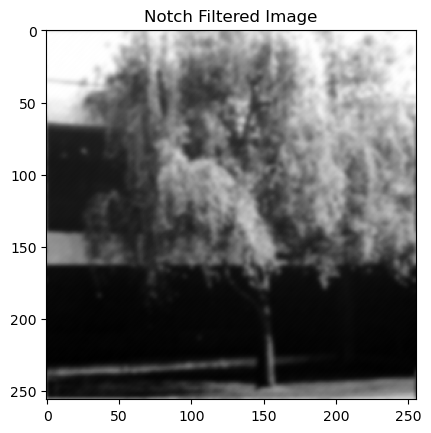

In [ ]:
H_total = H * G_LP

F_filtered = F_noisy * H_total
f_filtered = np.fft.ifft2(np.fft.ifftshift(F_filtered)).real
plt.imshow(f_filtered, cmap='gray')
plt.title('Notch Filtered Image')
plt.show()


The image above shows a well filtered image. This indicates that combining the low pass gaussian with the notch filter is good at removing the unwanted periodic noise. The notch takes care of removing the sharp stripe artifacts, while the gaussian filter takes care of smoothing the image, removing the unwanted artifacts totally.  